In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, layers

import matplotlib.pyplot as plt
import seaborn as sns

import pygal

from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import os
if not os.path.exists('./output'):
    os.makedirs('./output')

# Data Processing

In [2]:
raw_data = pd.read_csv("covid_19.csv")
df = raw_data.copy()
df.drop([0,1], inplace = True)
df.drop(["Lat","Long"], axis = 1, inplace = True)
df.index = df["Unnamed: 0"]
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.index.name = 'Country'
df = df.astype(int)
difference = df.diff(axis=1).drop('2020/1/22', axis = 1)
difference.head()

,2020/1/23,2020/1/24,2020/1/25,2020/1/26,2020/1/27,2020/1/28,2020/1/29,2020/1/30,2020/1/31,2020/2/1,...,2020/4/3,2020/4/4,2020/4/5,2020/4/6,2020/4/7,2020/4/8,2020/4/9,2020/4/10,2020/4/11,2020/4/12
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,18.0,50.0,18.0,56.0,21.0,40.0,37.0,34.0,52.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,29.0,28.0,16.0,6.0,17.0,9.0,7.0,17.0,13.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,185.0,80.0,69.0,103.0,45.0,104.0,94.0,95.0,64.0,89.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,27.0,35.0,24.0,20.0,19.0,19.0,18.0,0.0,37.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,4.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0


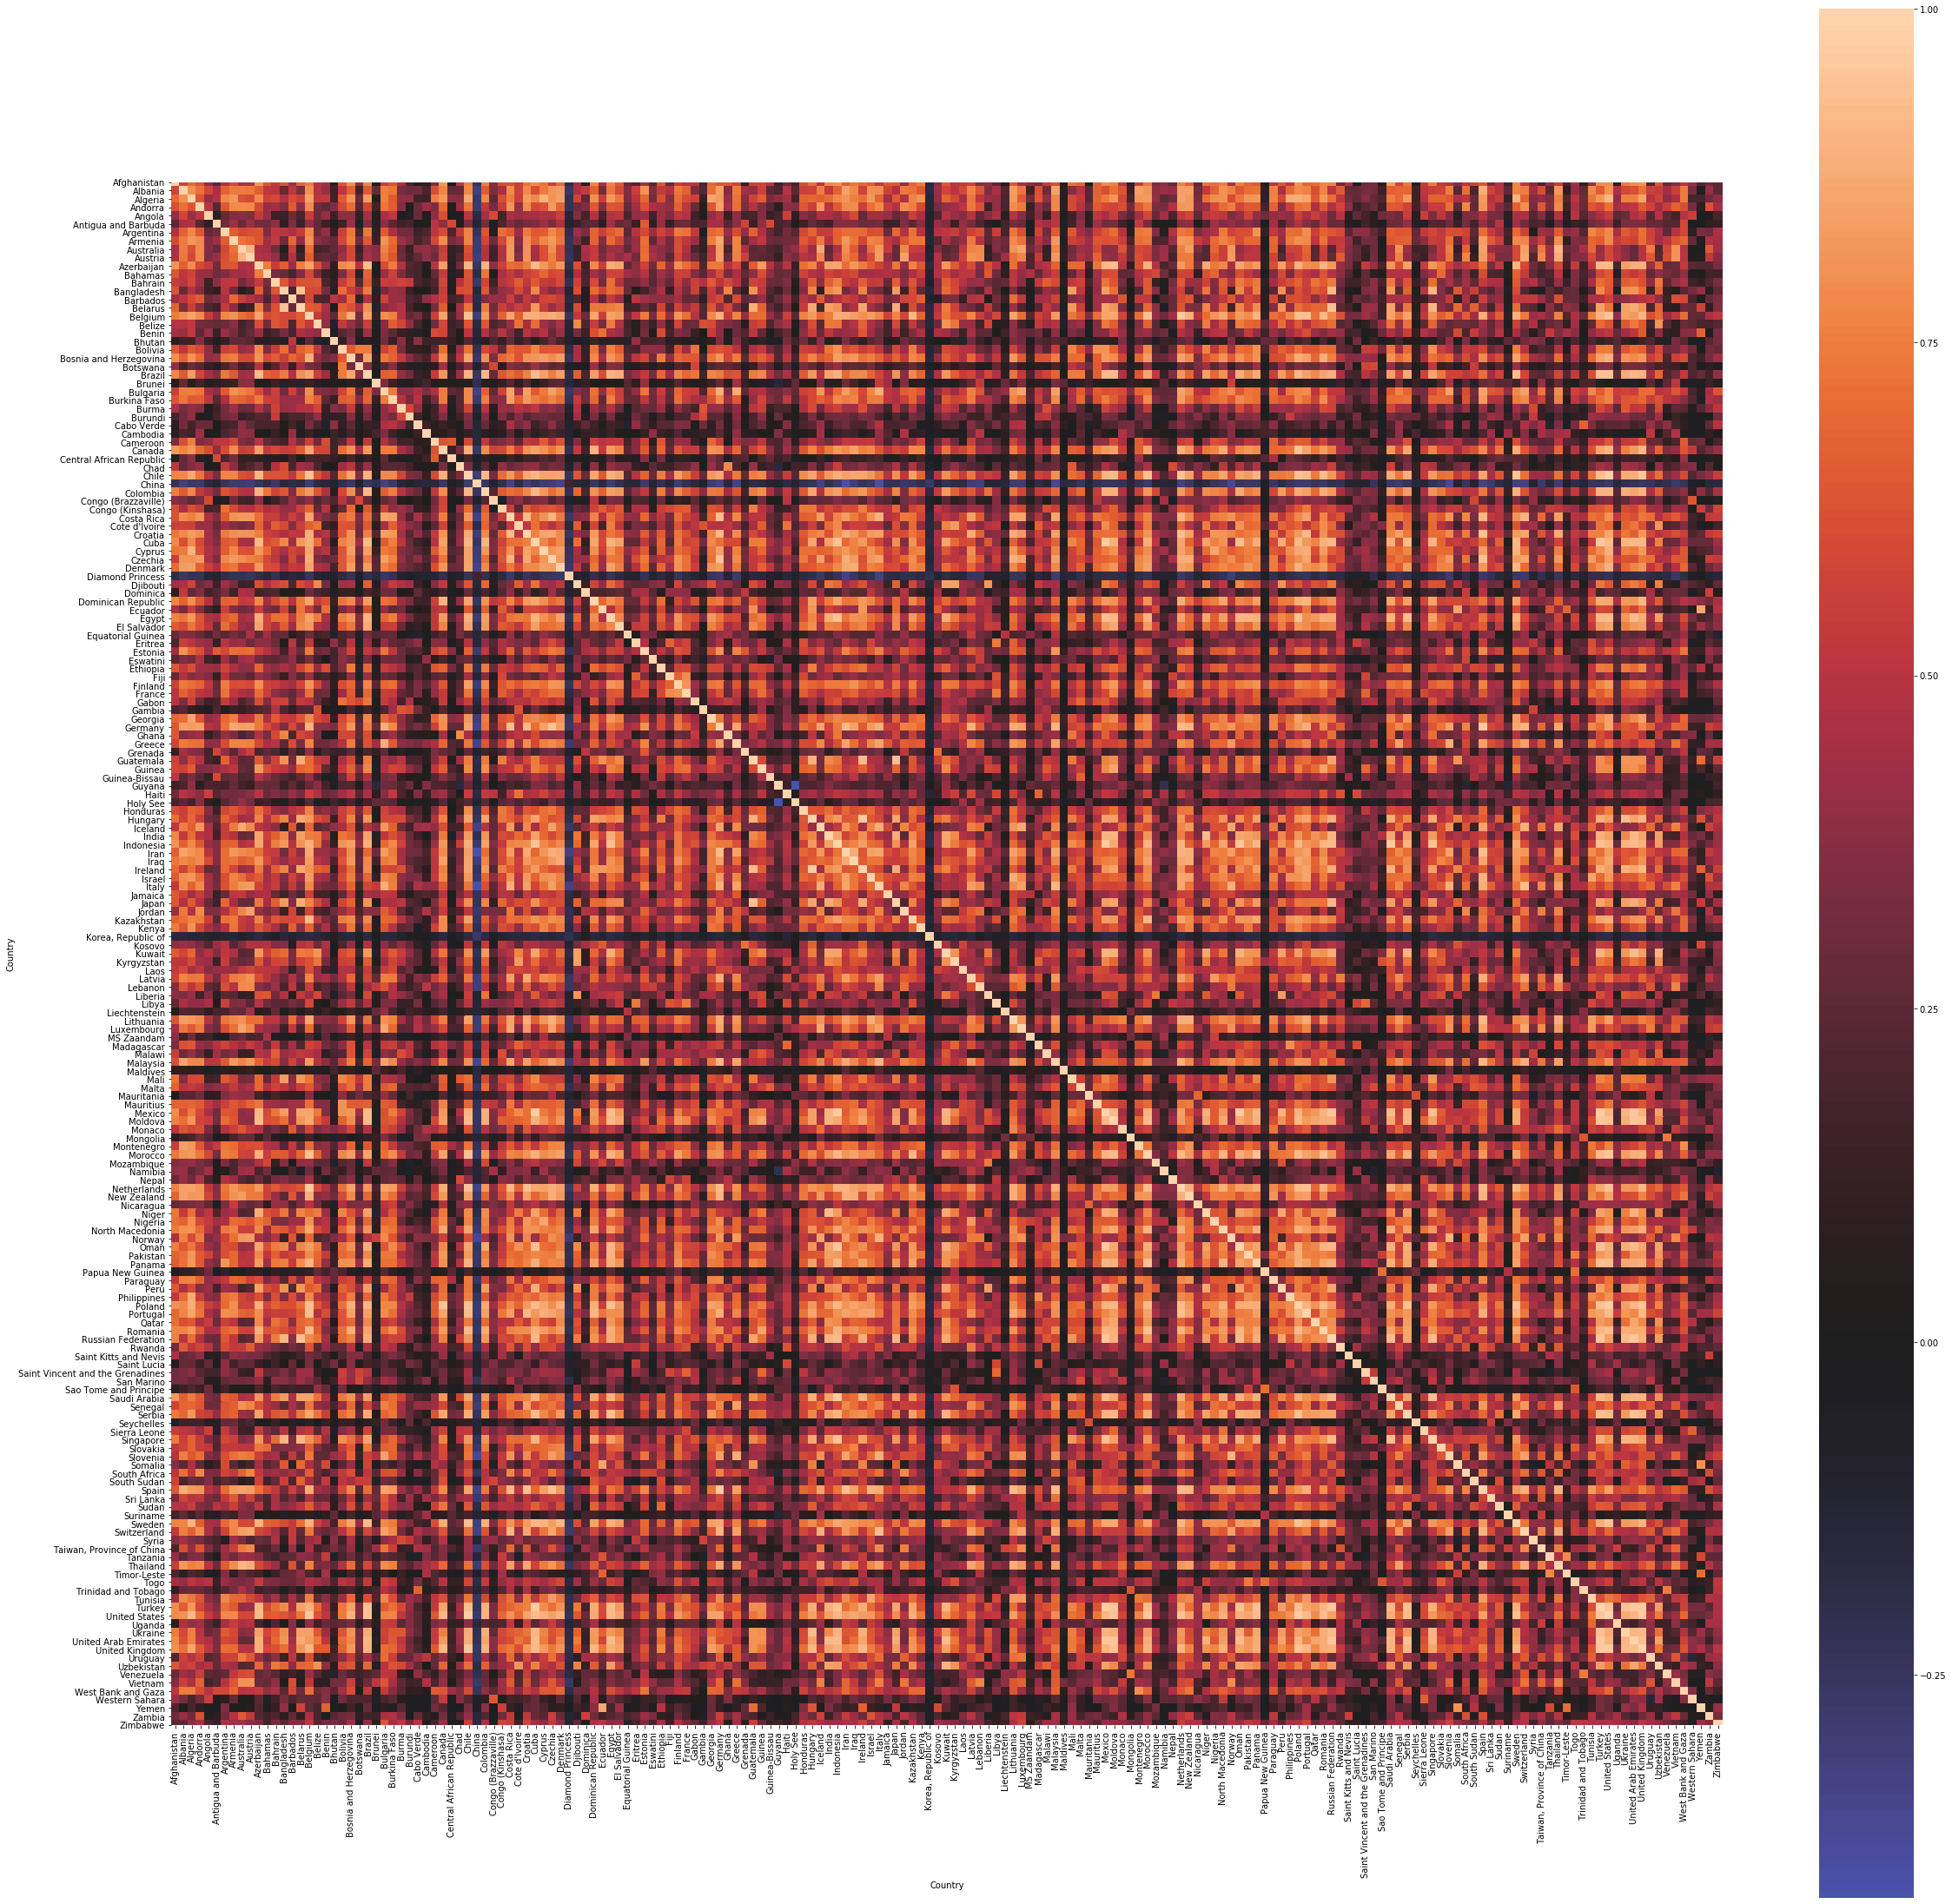

In [4]:
corr = difference.T.corr()
ticklabels = [i for i in difference.index]
plt.figure(figsize = (40,40))
sns.heatmap(corr,
            square= True,
            center=0,
            yticklabels= ticklabels,
            xticklabels= ticklabels)
#plt.savefig("./output/corr", dip = 300)

C_name = corr[(abs(corr > 0.7)) & (corr != 1)].dropna(how = 'all').index
C = difference.loc[C_name]

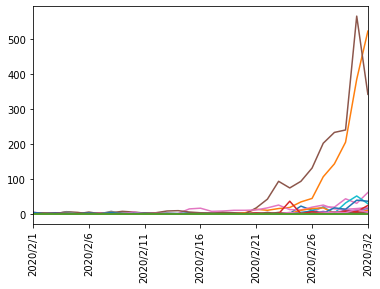

In [5]:
C.iloc[:,9:40].T.plot.line(legend = False)
plt.xticks(rotation = 90)
plt.show()

In [16]:
def dataSlice(data, start_index, interval_len):
    xs = []
    labels = []
    iterated = (data.shape[1]-start_index)/interval_len
    for i in range(int(iterated)):
        xs.append(data.iloc[:, start_index + interval_len*i : start_index + interval_len*(i+1)])
    x = deepcopy(xs)

    for i in range(int(iterated)-1):
        labels.append(np.where((x[i].iloc[:,-1] < x[i].iloc[:,0]), 1, 0))
        x[i]['label'] = labels[-1]
    return x[:-1]

def dataStack(List):
    for i in range(len(List)):
        List[i] = np.array(List[i])
    df = pd.DataFrame(np.vstack(List))
    return df

def dataSeq(data, interval_len):
    X = data.drop(interval_len, axis = 1)
    y = data[interval_len]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    X_train = np.array(X_train).astype(np.float32).reshape(-1, interval_len, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test).astype(np.float32).reshape(-1, interval_len, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

In [13]:
def subSeq(data, L):
    xs = []
    labels = []
    dim = data.shape[1]
    for i in range(dim-L+1):
        xs.append(data.iloc[:, i:L+i])
    x = deepcopy(xs)
    
    for i in range(len(xs)-1):
        labels.append(np.where((x[i].iloc[:,-1] < x[i+1].iloc[:,-1]),1, 0))
        x[i]['label'] = labels[-1]
        
    data = pd.DataFrame(np.vstack(x[:-1]))
    X = data.drop(L, axis = 1)
    y = data[L]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    X_train = np.array(X_train).astype(np.float32).reshape(-1, L, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test).astype(np.float32).reshape(-1, L, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    return X_train, y_train, X_test, y_test

In [ ]:
def get_data(df_daily, n_day=5):
    data_ls = []
    for row in range(df_daily.shape[0]):
        print(row, end='\r')
        for period in range(df_daily.shape[1] - n_day):
            data_ls.append(df_daily.iloc[row, period:period+n_day+1].values)
    X = np.array(data_ls)
    
    label_ls = []
    for i in range(len(X)):
        if X[i, -1] > X[i, -2]:
            label_ls.append(1)
        else:
            label_ls.append(0)
    t = np.array(label_ls)
    X = np.delete(X, np.s_[5], axis=1)

    X = X.reshape(X.shape[0], X.shape[1], -1).astype(np.float32)
    t = t.reshape(t.shape[0], 1).astype(np.float32)
    print(f'X.shape : {X.shape}, t.shape : {t.shape}')
    return X, t
X, y = get_data(df_daily=C)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [70]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(7607, 5, 1)
(3261, 5, 1)
(7607, 1)
(3261, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


# Simple RNN

In [71]:
class RnnArch(Model):
    def __init__(self):
        super(RnnArch, self).__init__()
        self.RNN_layer1 = layers.SimpleRNN(64, activation = "tanh", return_sequences=True)
        self.RNN_layer2 = layers.SimpleRNN(128, activation = "tanh", return_sequences=False)
        self.RNN_layer3 = layers.Dense(128, activation = "relu")
        self.RNN_layer3 = layers.Dense(64, activation = "relu")
        self.RNN_output_layer = layers.Dense(units=1)
    
    # forward pass
    def call(self, inputs, apply_sigmoid = True):
        x = self.RNN_layer1(inputs)
        x = self.RNN_layer2(x)
        x = self.RNN_layer3(x)
        z = self.RNN_output_layer(x)
        if apply_sigmoid:
            y = tf.nn.sigmoid(z)
            return y
        return z

In [72]:
class RnnTrain(RnnArch):
    def __init__(self, X_train, y_train, X_test, y_test, epochs, batch_size):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.epochs = epochs
        self.batch_size = batch_size
        
    def train(self):
        self.trainAcc = []
        self.trainLoss = []
        self.testAcc = []
        
        optimizer = tf.optimizers.Adam(learning_rate = 0.001)

        for epoch in range(self.epochs):
            ind = np.random.permutation(range(len(self.X_train)))
            for i in range(0, len(self.X_train), self.batch_size):
                mini_batch_ind = ind[i : i+self.batch_size]
                X_mini_batch = self.X_train[mini_batch_ind]
                y_mini_batch = self.y_train[mini_batch_ind]  

                with tf.GradientTape() as tape:
                    loss = self.computeLoss(inputs = X_mini_batch, labels = y_mini_batch)

                parameters = self.trainable_variables
                grades = tape.gradient(loss, parameters)
                optimizer.apply_gradients(zip(grades, parameters))
                
            print("====Epoch:{}====".format(epoch+1), end='\r')
            if (epoch == 0) or ((epoch+1) % 10 == 0):
                 # Training data info
                y_hat_train = self.call(X_train, apply_sigmoid=True)
                train_acc = self.accuracy(y_train, y_hat_train)
                
                # Testing data info
                y_hat_test = self.call(X_test, apply_sigmoid = True)
                test_acc = self.accuracy(y_test, y_hat_test)

                self.trainAcc.append(train_acc.numpy())
                self.trainLoss.append(loss.numpy())
                self.testAcc.append(test_acc.numpy())

                print('===Epoch: {0}==='.format(epoch+1))
                print('Training Loss: {0: .4f}, Training Accuracy{1: .4f}, Testing Accuracy{2: .4f}' \
                      .format(self.trainLoss[-1], self.trainAcc[-1], self.testAcc[-1]))
                

    def computeLoss(self, inputs, labels):
        y_pred = self.call(inputs,apply_sigmoid=False)
        y_true = tf.cast(labels, tf.float32)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        return tf.reduce_mean(loss)

    def accuracy(self, y_true, y_pred):
        predicted_class = tf.greater(y_pred,0.5)
        correct = tf.equal(tf.equal(y_true, 1), predicted_class)
        acc = tf.reduce_mean(tf.cast(correct, tf.float32))
        return acc

In [73]:
#L = dataSlice(data= C, start_index=1, interval_len=10)
#data = shuffle(dataStack(List=L))
#X_train, y_train, X_test, y_test = dataSeq(data=data, interval_len=10)
#X_train, y_train, X_test, y_test = subSeq(data = C, L=10)
# Data info
'''
print("Training data points: ", X_train.shape[0])
print("Testing data points: ", X_test.shape[0])
print("Class labels: ", np.unique(y_train))
print("Training Data Decrease Proportion: ", len(y_train[y_train == 0])/len(y_train))
'''
RNN = RnnTrain(X_train, y_train, X_test, y_test, epochs=100, batch_size=50)
RNN.train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

===Epoch: 1====
Training Loss:  0.4689, Training Accuracy 0.8066, Testing Accuracy 0.8007
===Epoch: 10====
Training Loss:  0.3716, Training Accuracy 0.8158, Testing Accuracy 0.8016


KeyboardInterrupt: 

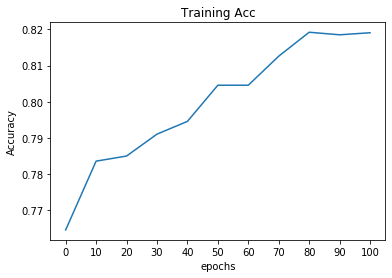

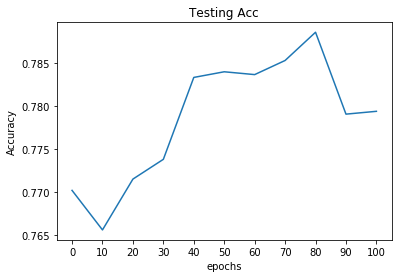

In [28]:
plt.plot(RNN.trainAcc)
plt.title("Training Acc")
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.xticks([i for i in range(0, 11)],[s for s in range(0, 110, 10)])
plt.savefig("./output/RNNTrainingAcc")
plt.show()

plt.plot(RNN.testAcc)
plt.title("Testing Acc")
plt.ylabel("Accuracy")
plt.xlabel("epochs")
plt.xticks([i for i in range(0, 11)],[s for s in range(0, 110, 10)])
plt.savefig("./output/RNNTestingAcc")
plt.show()

In [ ]:
class LSTMArch(Model):
    def __init__(self):
        super(LSTMArch, self).__init__()
        self.LSTM_layer1 = layers.LSTM(16, activation = "tanh", return_sequences=True)
        self.LSTM_layer2 = layers.LSTM(8, activation = "tanh", return_sequences=False)
        self.LSTM_layer3 = layers.Dense(8, activation="sigmoid")
        self.LSTM_output_layer = layers.Dense(1)
        
    def call(self, inputs, apply_sigmoid = True):
        x = self.LSTM_layer1(inputs)
        x = self.LSTM_layer2(x)
        x = self.LSTM_layer3(x)
        z = self.LSTM_output_layer(x)
        if apply_sigmoid:
            y = tf.sigmoid(z)
            return y
        return z

In [ ]:
class LstmTrain(LSTMArch):
    def __init__(self, X_train, y_train, X_test, y_test, epochs, batch_size):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.epochs = epochs
        self.batch_size = batch_size
        
    def train(self):
        self.trainAcc = []
        self.trainLoss = []
        self.testAcc = []
        
        optimizer = tf.optimizers.Adam(learning_rate = 0.001)

        for epoch in range(self.epochs):
            ind = np.random.permutation(range(len(self.X_train)))
            for i in range(0, len(self.X_train), self.batch_size):
                mini_batch_ind = ind[i : i+self.batch_size]
                X_mini_batch = self.X_train[mini_batch_ind]
                y_mini_batch = self.y_train[mini_batch_ind]  

                with tf.GradientTape() as tape:
                    loss = self.computeLoss(inputs = X_mini_batch, labels = y_mini_batch)

                parameters = self.trainable_variables
                grades = tape.gradient(loss, parameters)
                optimizer.apply_gradients(zip(grades, parameters))
                
            print("====Epoch:{}====".format(epoch+1), end='\r')
            if (epoch == 0) or ((epoch+1) % 10 == 0):
                 # Training data info
                y_hat_train = self.call(X_train, apply_sigmoid=True)
                train_acc = self.accuracy(y_train, y_hat_train)
                
                # Testing data info
                y_hat_test = self.call(X_test, apply_sigmoid = True)
                test_acc = self.accuracy(y_test, y_hat_test)

                self.trainAcc.append(train_acc.numpy())
                self.trainLoss.append(loss.numpy())
                self.testAcc.append(test_acc.numpy())

                print('===Epoch: {0}==='.format(epoch+1))
                print('Training Loss: {0: .4f}, Training Accuracy{1: .4f}, Testing Accuracy{2: .4f}' \
                      .format(self.trainLoss[-1], self.trainAcc[-1], self.testAcc[-1]))
                

    def computeLoss(self, inputs, labels):
        y_pred = self.call(inputs,apply_sigmoid=False)
        y_true = tf.cast(labels, tf.float32)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        return tf.reduce_mean(loss)

    def accuracy(self, y_true, y_pred):
        predicted_class = tf.greater(y_pred,0.5)
        correct = tf.equal(tf.equal(y_true, 1.0), predicted_class)
        acc = tf.reduce_mean(tf.cast(correct, tf.float32))
        return acc

In [ ]:
#L = dataSlice(data= C, start_index=21, interval_len=2)
#data = shuffle(dataStack(List=L))
#X_train, y_train, X_test, y_test = dataSeq(data=data, interval_len=2)
X_train, y_train, X_test, y_test = subSeq(data = C, L = 10)
# Data info
print("Training data points: ", X_train.shape[0])
print("Testing data points: ", X_test.shape[0])
print("Class labels: ", np.unique(y_train))
print("Training Data Decrease Proportion: ", len(y_train[y_train == 0])/len(y_train))

LSTM_2 = LstmTrain(X_train, y_train, X_test, y_test, epochs=100, batch_size=50)
LSTM_2.train()

In [ ]:
L = dataSlice(data= C, start_index=1, interval_len=20)
data = shuffle(dataStack(List=L))
X_train, y_train, X_test, y_test = dataSeq(data=data, interval_len=20)
# Data info
print("Training data points: ", X_train.shape[0])
print("Testing data points: ", X_test.shape[0])
print("Class labels: ", np.unique(y_train))
print("Training Data Decrease Proportion: ", len(y_train[y_train == 0])/len(y_train))
print("Training Data Decrease Proportion: ", len(y_test[y_test == 0])/len(y_test))

LSTM_10 = LstmTrain(X_train, y_train, X_test, y_test, epochs=100, batch_size=20)
LSTM_10.train()

In [ ]:
countries_dict = pygal_maps_world.maps.COUNTRIES
def getCountryCode(country_name):
    for code,name in countries_dict.items():
        if country_name == name:
            return  code
    return None
country_code = []
for countries_name in list(difference.index):
    country_code.append(getCountryCode(countries_name))

last = difference.iloc[:,-2:].values.astype(np.float32).reshape(-1, 2, 1)
prob_each_country = LSTM_2.call(last).numpy()
each_country = pd.DataFrame(prob_each_country, country_code)
each_country = each_country.reset_index().dropna().set_index('index')
ascending = each_country[each_country > 0.5].dropna().to_dict()[0]
descending = each_country[each_country <= 0.5].dropna().to_dict()[0]
worldmap = pygal_maps_world.maps.World()
worldmap.title = 'Probability of the number of confirmed people will increase in the next day for each country'
worldmap.add('ascending',ascending)
worldmap.add('descending', descending)
worldmap.render_to_file('./output/worldmap.svg')

X.shape : (10868, 5, 1), t.shape : (10868,)
